# Matrix Completion

in this notebook we're going to try to reconstruct an image , only having a few persentage of all pixels . we all know that pixels of an image are highly correlated , particularly those that are adjacent . we don't expect that there will be so many discontinuity in the image and that's why we expect that this high dimensional vector lie on a low dimensional structure or at least it could be approximated by an element of that low-dimensional structure .

In [22]:
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [41]:
d = os.getcwd()
observatory = np.array(Image.open(os.path.join(d,'astro4f1.jpg')).convert('L'))

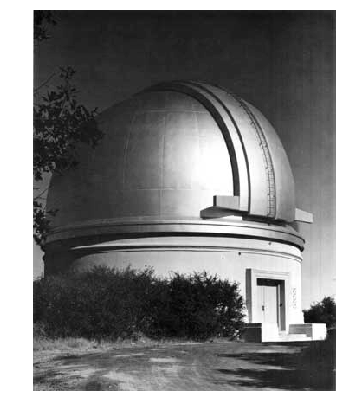

In [58]:
plt.figure(figsize=(10,7))
plt.imshow(observatory , cmap = plt.cm.gray)
plt.axis('off') ;

the most simplest structure will be subspaces !! so let us think of it as the rank of the picture .so now let $X$ be our image . then $X \in \mathbf{R}^{m \times n} $ . now let us see which kind of structure we want to use . let us define $C = \{ Y \: | \: Y \in \mathbf{R}^{m \times n} , \: rank(Y) \le r \} $ (F.Y.I this is not a subspace!) so let us first see from what dimension this monster lives in . we know that every matrix has a unique singular value decomposition , $X = UDV^{T} $ where $ U \in \mathbf{R}^{m \times r} ,\: V \in \mathbf{R}^{r \times n} $ are unitary matrices and $D$ is diagonal . because of one-to-one correspondence we only need to find degrees of freedom of an arbitary unitary matrix which is $ (m-1) + (m-2) + ... + (m-r) \approx r.m $ so the degrees of freedom of $C$ will be at most $ r(n+m) $ which is much lower than $m \times n$ when $r$ is small . but there is a problem! this set is not convex !! which tells us that there will be no garauntee for convergance for our optimization methods .fortunately there might be a solution for this . Comvex Hull !! but this is not a Bounded Set , so first we need to bound our Domain . (i'll cheat a little bit here ) if we take $B = \{ Y \: | \: Y \in \mathbf{R}^{m \times n} ,\: ||Y||_* \le \delta \} \cap C $ so now if we take the Convex Hull of this set we will have $Conv(B) = \{ Y \: | \: Y \in \mathbf{R}^{m \times n} ,\: ||Y||_* \le \delta \} $ which is the $l_{1}$ ball and this is a convex set . 

# Singular Value Decomposition

As we can see the singular values are decaying very quickly . (actually this is because of the big bias of pixels  , i mean if we assume the image is a noisy version of reality these normal random variables are not zero mean . but if we could some how make that happenned the singular value decomposition would be much different . it should decay linearly ) what if we only hold 15 largest singular values ,what would happen ?

In [52]:
import mpld3
u , s , vh = svd(observatory)
s = s[:100]
fig = plt.figure()
plt.bar(np.arange(0,len(s)) , s)
mpld3.display(fig)

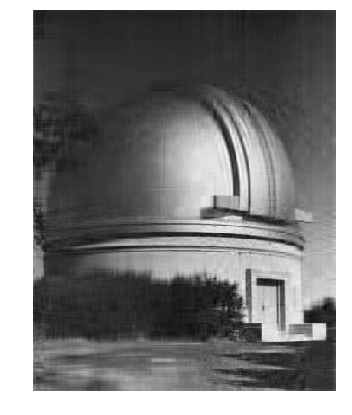

In [303]:
low_rank_image = np.dot(u[:,:25] * s[:25] , vh[:25,:])
plt.figure(figsize=(10,7))
plt.imshow(low_rank_image ,cmap = plt.cm.gray)
plt.axis('off');

# Projection 

in this section we want to find an explicit formula for the projection of an arbitrary point in the space onto set $C$ , although this might not be eligible and might not be unique (because it is not convex) but the algorithm is ubiquitous and exquisite!! first let us make clear that what we mean by projection :

$$ P_{C}(X) = \max_{Y \in C}{||X-Y||_{Fro}^2} $$

the main reason we chose Frobenius norm is that it is because if we vectorize our matrices then it is equivalant to euclidean norm in this space. now we want to prove that if we only hold $r$ greatest singular values and form the new matrix it will minimize our objective . take a look at $\href{https://en.wikipedia.org/wiki/Low-rank_approximation}{Wikipedia}$ Page for proof . the latter image has the following property . it is the projection of our image on $C_{15}$ which is the best low rank(15-rank) approximation of our image . 
the other projection is from an arbitary point on $B_{\delta}$ which is Soft Thresholding . 

In [304]:
def project_on_lowrank(X ,r):
    
    u, s, vh = np.linalg.svd(X)
    return np.dot(u[:,:r]*s[:r] , vh[:r,:])

def project_on_ball(X,delta):
    
    u , s, vh = np.linalg.svd(X)
    
    j = s.cumsum() - np.arange(1,len(s)+1) * s
    
    index = 0
    for i , val in enumerate(j):
        if val > delta:
            index = i-1
            break
    
    lambda_hat = (s[:index+1].sum() - delta) / float(index + 1)
    s_proj = s[s > lambda_hat] - lambda_hat
    return np.dot(u[:,:index+1] * s_proj , vh[:index+1,:])    
    

# Optimization Problem

so now we need to formulate out problem . Matrix Completion !! just kidding . let $ \mathcal{P}_{I} $ be the linear operator that set the values in the indices $I^{c}$ to zero and set others to themselves . so we will have some observed pixels that here we first assume there is no noise and we observed them , so we want to fill other unobserved values without changing these observed values .

$$ \min_{ \mathcal{P}_{I}(Y) = \mathcal{P}_{I}(X) }{ rank(Y) } $$

but this problem is not convex but , let's try it out and see what happens if we project !! there is a theorem for two compact convex sets that if we alternatively project on them then we will converge whether in the intersection of these two sets or to a pair of points which has the minimum distance property of the two sets . so we are going to take our chances ! 

In [305]:
np.random.seed(1)
total_elem = np.prod(observatory.shape,dtype=np.int)
I = np.random.choice( total_elem, int(0.3*total_elem) , replace=False)
row = [ i % observatory.shape[0] for i in I]
col = [ i / observatory.shape[0] for i in I]

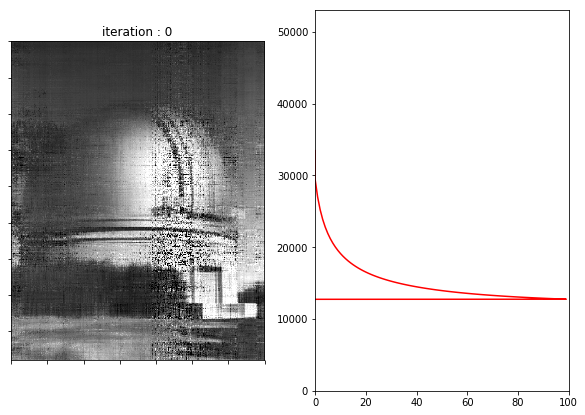

In [306]:
from matplotlib import animation , rc
from IPython.display import HTML

fig = plt.figure(figsize=(10,7))
ax = fig.subplots(1,2)
image = np.zeros_like(observatory)
image[row,col] = observatory[row,col]

im = ax[0].imshow(image , animated=True , cmap = plt.cm.gray)
xData , yData = [] ,[]
line , =  ax[1].plot(xData , yData,color='r')
ax[1].set_xlim([0,100])
ax[1].set_ylim([0 , np.linalg.norm(image - observatory)])
ax[0].set_title('iteration : 0')
ax[0].xaxis.set_major_formatter(plt.NullFormatter())
ax[0].yaxis.set_major_formatter(plt.NullFormatter())    

def update_image(frame , *args):
    # assuming args : rank for projection
    global image 
    image = project_on_lowrank(image , args[0])
    
    # project on observation linear space
    
    image[row,col] = observatory[row,col]
    
    im.set_array(image)
    ax[0].set_title('iteration : %d' % frame)
    
    xData.append(frame)
    yData.append(np.linalg.norm(image - observatory))
    line.set_data(xData,yData)
    
    return ax,im , line

anim = animation.FuncAnimation(fig , update_image ,range(100),interval=100,fargs=(25,), blit=False )
rc('animation',html='html5')
anim

not bad for a non-convex function hah!? please consider the hyper parameters here also . project on rank-25 and we observe 30 percent of data exactly . now let's try to project on the convex hull of this set.

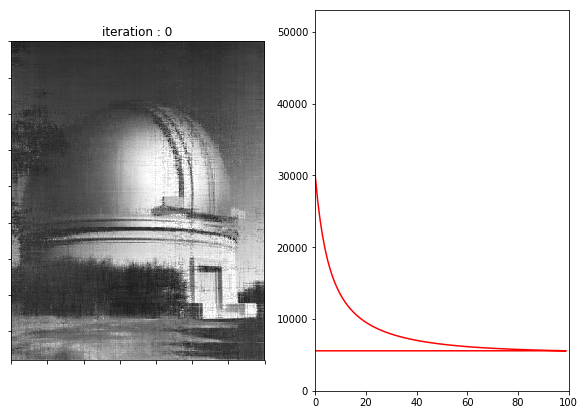

In [307]:
fig = plt.figure(figsize=(10,7))
ax = fig.subplots(1,2)
image = np.zeros_like(observatory)
image[row,col] = observatory[row,col]

im = ax[0].imshow(image , animated=True , cmap = plt.cm.gray)
xData , yData = [] ,[]
line , =  ax[1].plot(xData , yData,color='r')
ax[1].set_xlim([0,100])
ax[1].set_ylim([0 , np.linalg.norm(image - observatory)])
ax[0].set_title('iteration : 0')
ax[0].xaxis.set_major_formatter(plt.NullFormatter())
ax[0].yaxis.set_major_formatter(plt.NullFormatter())    

_,s,_ = np.linalg.svd(observatory)
delta = s[:25].sum()

def update_image_ball(frame , *args):
    # assuming args : delta for projection
    global image 
    image = project_on_ball(image , args[0])
    
    # project on observation linear space
    
    image[row,col] = observatory[row,col]
    
    im.set_array(image)
    ax[0].set_title('iteration : %d' % frame)
    
    xData.append(frame)
    yData.append(np.linalg.norm(image - observatory))
    line.set_data(xData,yData)
    
    return ax,im , line

anim = animation.FuncAnimation(fig , update_image_ball ,range(100),interval=100,fargs=(delta,), blit=False )
anim

# Projection free

But both of those methods were extremely computationally hard . because we have to compute almost the whole singular
value decomposition . in this method for solving our convex optimization as follows . at eatch iteration we will approximate out objective function with a linear function and we will optimize that function over our convex set :

$$ arg\min_{x \in \mathcal{K}} {f(x)} \:\approx\: arg\min_{x \in \mathcal{K}} {<\nabla f(x_0),x>} $$

but this approximation is only true when the step size is small enough . so after solving the latter problem we will move to the point $ x^{(n-1)} + \lambda(y^{(n)} - x^{(n-1)}) $ .
so we know that optimizaing a linear objective over a convex set will occur only on extreme points . so we need to find our extreme points here . first let us relax our optimization problem by assuming there was some noise in observing those pixels so now we want to solve this problem :

$$ \min_{||Y||_* \le \delta}{||\mathcal{P}_{I}(X)-\mathcal{P}_{I}(Y)||_{Fro}^2} $$

which we will solve this ,by the projection free algorithm so we need to be able to find the solution of :

$$ \min_{ ||Y||_* \le \delta}{ <2(\mathcal{P}_{I}(Y_0)-\mathcal{P}_{I}(X)) , Y > } $$

consider that our objective function is a combination of an affine transformation and frobenius norm thus our objective is convex and the first order approximation lies under the epigraph !and because the objective is a linear function ,we know that this minimization occurs at the extreme point of ball $||Y||_* \le \delta $ but the extreme points of this ball are rank-1 matrices with only one singular value equal to $\delta$ and every other point in this set will be a convex combination of these extreme points . assuming $ 2(\mathcal{P}_{I}(Y_0)-\mathcal{P}_{I}(X)) = U\Sigma V^T $ then the solution will be $ \bar{Y} = \delta u_1 v_{1}^{T} $ so it is much more computationally efficient because only the largest singular value and vectors must be computed . let's try it out !

In [310]:
from scipy.sparse.linalg import svds
from scipy.sparse import coo_matrix ,csc_matrix

def P_I(X):
    Y = coo_matrix((X[row,col],(row,col))).tocsc()
    return Y

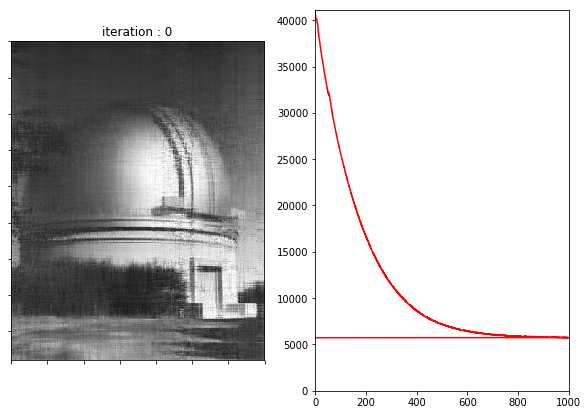

In [312]:
fig = plt.figure(figsize=(10,7))
ax = fig.subplots(1,2)
P_I_X = P_I(observatory).astype('float')
image = P_I_X.toarray()

im = ax[0].imshow(image , animated=True , cmap = plt.cm.gray)
xData , yData = [] ,[]
line , =  ax[1].plot(xData , yData,color='r')
ax[1].set_xlim([0,1000])
ax[1].set_ylim([0 , np.linalg.norm(image - observatory)])
ax[0].set_title('iteration : 0')
ax[0].xaxis.set_major_formatter(plt.NullFormatter())
ax[0].yaxis.set_major_formatter(plt.NullFormatter())    

_,s,_ = np.linalg.svd(observatory)
delta = s[:25].sum()
Lambda = 5e-3


def update_image_projfree(frame , *args):
    # assuming args : delta for projection , Lambda for step size
    global image 
    
    u , s , v = svds(P_I(image) - P_I_X , k=1)
    
    image += args[1]*(-np.outer(u,v)*args[0] - image)
    
    im.set_array(image)
    ax[0].set_title('iteration : %d' % frame)
    
    xData.append(frame)
    yData.append(np.linalg.norm(image - observatory))
    line.set_data(xData,yData)
    
    return ax,im , line

anim = animation.FuncAnimation(fig , update_image_projfree ,range(1000),interval=10,fargs=(delta,Lambda), blit=False )
anim

# Proximal Gradient Descent

let us define the proximal function :

$$ prox_{t}(x) = arg\min_{y}{ \frac{1}{2t}||x-y||_{2}^2 + f(y) }$$

when the function $f$ is the indicator function of a convex set then proximal function is equivalant to projection from an arbitary point onto your set !! so what we want to do here is to 

$\\ \bullet \text{ move along the gradient with a fixed step size}  \\ \bullet \text{project onto our ball} $

do this untill convergance .in here we have a hyper parameter which is the gradient step .theoritically we know that if our gradient is $L$ Lipschitz then step size $\frac{1}{L}$ is good to go! ortunately our gradient is linear so it will be Lipschitz 

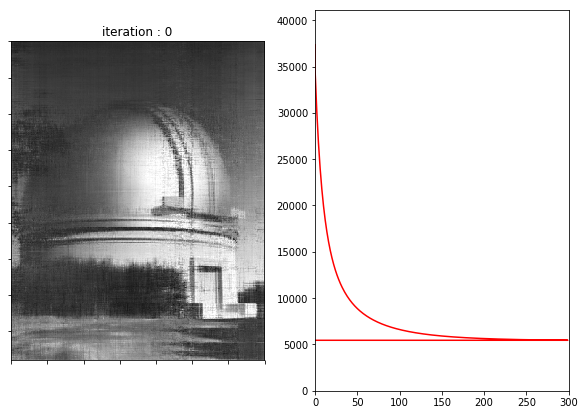

In [288]:
fig = plt.figure(figsize=(10,7))
ax = fig.subplots(1,2)
image = np.zeros(shape=observatory.shape,dtype='float')
image[row,col] = observatory[row,col]
P_I_X = image.copy()

im = ax[0].imshow(image , animated=True , cmap = plt.cm.gray)
xData , yData = [] ,[]
line , =  ax[1].plot(xData , yData,color='r')
ax[1].set_xlim([0,300])
ax[1].set_ylim([0 , np.linalg.norm(image - observatory)])
ax[0].set_title('iteration : 0')
ax[0].xaxis.set_major_formatter(plt.NullFormatter())
ax[0].yaxis.set_major_formatter(plt.NullFormatter())    

_,s,_ = np.linalg.svd(observatory)
delta = s[:25].sum()
step_size = 5e-1

def P_I(X):
    Y = np.zeros_like(X)
    Y[row,col] = X[row,col]
    return Y

def update_image_prox(frame , *args):
    # assuming args : delta for projection , step size
    global image
    
    image -= (P_I(image)-P_I_X)*args[1]
    
    image = project_on_ball(image , args[0])
    
    im.set_array(image)
    ax[0].set_title('iteration : %d' % frame)
    
    xData.append(frame)
    yData.append(np.linalg.norm(image - observatory))
    line.set_data(xData,yData)
    
    return ax,im , line

anim = animation.FuncAnimation(fig , update_image_prox ,range(300),interval=50,fargs=(delta,step_size), blit=False )
anim

# Accelerated Proximal Gradient Descnet

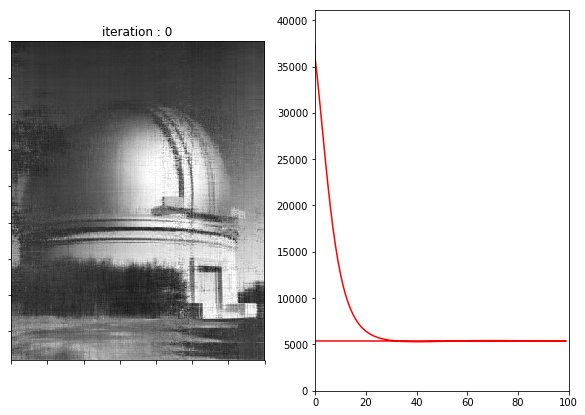

In [294]:
fig = plt.figure(figsize=(10,7))
ax = fig.subplots(1,2)
image = np.zeros(shape=observatory.shape,dtype='float')
image[row,col] = observatory[row,col]
P_I_X = image.copy()
prev_image = image.copy()

im = ax[0].imshow(image , animated=True , cmap = plt.cm.gray)
xData , yData = [] ,[]
line , =  ax[1].plot(xData , yData,color='r')
ax[1].set_xlim([0,100])
ax[1].set_ylim([0 , np.linalg.norm(image - observatory)])
ax[0].set_title('iteration : 0')
ax[0].xaxis.set_major_formatter(plt.NullFormatter())
ax[0].yaxis.set_major_formatter(plt.NullFormatter())    

_,s,_ = np.linalg.svd(observatory)
delta = s[:25].sum()
step_size = 5e-1

def P_I(X):
    Y = np.zeros_like(X)
    Y[row,col] = X[row,col]
    return Y

def update_image_prox_accel(frame , *args):
    # assuming args : delta for projection , step size
    global image , prev_image
    
    v = image + (frame-1)/float(frame+2) * (image - prev_image)
    
    prev_image = image.copy()
    
    image = v - (P_I(v)-P_I_X)*args[1]
    
    image = project_on_ball(image , args[0])
    
    im.set_array(image)
    ax[0].set_title('iteration : %d' % frame)
    
    xData.append(frame)
    yData.append(np.linalg.norm(image - observatory))
    line.set_data(xData,yData)
    
    return ax,im , line

anim = animation.FuncAnimation(fig , update_image_prox_accel ,range(100),
                               interval=100,fargs=(delta,step_size), blit=False )
anim

# Timing and Computational Complexity

In [302]:
image = np.zeros(shape=observatory.shape,dtype='float')
image[row,col] = observatory[row,col]

%timeit update_image_prox_accel(0,delta,step_size)
%timeit update_image_prox(0,delta,step_size)
%timeit update_image(0,25)
%timeit update_image_projfree(0,delta,Lambda)

10 loops, best of 3: 59.5 ms per loop
10 loops, best of 3: 58.6 ms per loop
10 loops, best of 3: 59.4 ms per loop
10 loops, best of 3: 19.6 ms per loop


as we can see the accelerated proximal descent algorithm is very fast for convergance and makes sence to use it . but be aware that using it need some careful causiousness . in here because the objective is quadratic therefore , gradient will be linear and Lipschitz and you need this condition for convergance . but this algorithm has a high complexity and there is a trade off between complexity and rate of convergance !! as we can see projection free algorithm doesn't do bad at all but it takes much longer , more than 10 times of iteration !! but as you can see it's 2 times faster so depencding on your scale of image and sparsity of your observation you may want to consider this trade off .